Epigenetic Reader Protein Binding  
============================

Self-consistent field theory for multiple marks
------------------------------------------------------

Questions:

    -in eval_f_bind why introduce j_int. In theory had (0 marks 2 bound) = (0 marks 0 bound). Is it to take self-interaction into account? 
    - based on overleaf doc, only need <s> to get f bar, which can then use to get <s_i s_j>, correct? similar to what was done below with s2_bind
    - how to verify <s_i s_j>, or (eventually) structure factor? simulation data to compare to?

In [1]:
import sys
sys.path.insert(1, './wlcstat/')

In [2]:
import numpy as np
import scipy.special as sp
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [3]:
def eval_f_bind(n_b, n_m, e_m = -1.5, j_int = -3.92):
    r"""
    eval_f_bind - Evaluate the binding free energy
    
    Parameters
    ----------
    n_b : integer
        Number of reader proteins bound to the nucleosome
    n_m : integer
        Number of marked tails
    e_me3 : float
        Favorable binding free energy to tri-methylated tails
        
    Returns
    -------
    f_bind : float
        Binding free energy
    
    """
    # Calculate the cases for the binding free energy
    f_bind = 0

    if n_b == 0:
        f_bind = 0
    elif n_b == 1:
        if n_m == 0:
            f_bind = -np.log(2)
        elif n_m == 1:
            f_bind = -np.log(1. + np.exp(-e_m))
        elif n_m == 2:
            f_bind = e_m - np.log(2)
    elif n_b == 2:
        if n_m == 0:
            f_bind = j_int
        elif n_m == 1:
            f_bind = e_m + j_int
        elif n_m == 2:
            f_bind = 2 * e_m + j_int
    
    return f_bind

In [4]:
def eval_opt_func(x, mu, e_m, v_int, f_om, phi_c):
    r"""
    eval_opt_func - Evaluate the binding state for 
    
    """

    # Convert to average bound variable and phi variable
    n_bind = len(mu) # number of reader protein types
    s_bind = 2. * np.exp(x) / (1 + np.exp(x))
    
    phi_bind = np.zeros(n_bind)
    for mark in range(n_bind):
        ind0 = mark * 3 
#         phi_bind[mark] = phi_c * np.sum(f_om[ind0:(ind0 + 2)] * s_bind[ind0:(ind0 + 2)]) # ORGINAL. OBOE
        phi_bind[mark] = phi_c * np.sum(f_om[ind0:(ind0 + 3)] * s_bind[ind0:(ind0 + 3)]) # MINE
    erg_int = np.matmul(v_int, phi_bind)
    
    # Evaluate the optimization function
    opt_func = np.zeros(n_bind * 3)
    
    ind = 0
    for mark in range(n_bind): # for each reader protein/ mark type
        for om in range(3): # for each possible number of marked tails on nucl
            f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
            f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
            q = 1 + np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])
            #calculate the difference b/w new and previous avg binding state 
            # FOR opt.fsolve:
            opt_func[ind] = s_bind[ind] - (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
                                             2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q        
#             # FOR opt.minimize
#             opt_func[ind] = (s_bind[ind] - (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
#                                              2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q)**2            
            
    
            ind += 1
    
    return opt_func

In [ ]:
# def eval_opt_func_wrapper(x, mu, e_m, v_int, f_om, phi_c):
#     opt_func = eval_opt_func(x, mu, e_m, v_int, f_om, phi_c)
# #     if sigma ==0:
# #         return [opt_func, x[1], x[2]]
# #     elif sigma ==1:
# #         return [x[0], opt_func, x[2]]
# #     elif sigma ==2:
# #         return [x[0], x[1], opt_func]
#     return np.sum(opt_func)

In [5]:
def eval_s_bind(mu, e_m, v_int, f_om, phi_c, x0, mu_fail_arr):
    # Convert to average bound variable and phi variable
    n_bind = len(mu)
    for mark in range(n_bind):
        ind0 = mark * 3
#         indf = ind0 + 2 # ORGINAL OBOE
        indf = ind0 + 3 # MINE
        f_om[ind0:indf] /= np.sum(f_om[ind0:indf])
    
    x = np.zeros(n_bind * 3)
    
#     x0 = np.zeros(n_bind * 3)
#     x0 = np.ones(n_bind * 3) * -20
    
#     data = (mu, e_m, v_int, f_om, phi_c)
    data = [mu, e_m, v_int, f_om, phi_c]

    #doing unbounded non-linear solver for x, then calc (bounded) var s_bind
    
    #OPTION 1: fsolve. failing
#     x = opt.fsolve(eval_opt_func, x0=x0, args=tuple(data), full_output = 0, maxfev = 100000, xtol = 1e-9)
#     x = ot[0]

#     #OPTION 2: minimize. NOT GOOD dealing w/local vs global min

#     x = opt.minimize(eval_opt_func_wrapper, x0=x0, args=tuple(data))
#     suc = x.success
#     msg = x.message
#     x = x.x
    
    #OPTION 3: least squares, same s fsolve
#     x = opt.least_squares(eval_opt_func, x0=x0, args=tuple(data))
#     x = x.x
    
#     #OPTION 4: root
    # trying "smaller steps" for midpoint scans
#     if x0[0] > -.0001 and x0[0] < 0.0001:
#         x = opt.root(eval_opt_func, x0=x0, args=tuple(data), method  ="df-sane", tol = 1e-5, \
#                      options={"sigma_eps":1e-3, "sigma_0": 1e-3})#, "maxfev": 1e6})
#     else:
#         x = opt.root(eval_opt_func, x0=x0, args=tuple(data), method  ="df-sane")

#     same step size for all scans (ideal soln)
#     x = opt.root(eval_opt_func, x0=x0, args=tuple(data), method  ="df-sane")
    x = opt.root(eval_opt_func, x0=x0, args=tuple(data))
#
    suc = x.success
    msg = x.message
    x = x.x
    
    test = eval_opt_func(x, mu, e_m, v_int, f_om, phi_c)
    if test[0]>0.0001 or not suc:
#     if not suc:
        print("failure at mu = ", str(mu))
        print("test: ", test)
        print("suc: ", suc)
        mu_fail_arr= np.append(mu, mu_fail_arr)
        print(msg)
#         print(test)
#         print("int var- 1 if soln was found: ", ot[2])
#         print(ot[3])
#         print(ot[1])
        print("------------------")
        return [np.nan, np.nan, np.nan], mu_fail_arr
    s_bind = 2. * np.exp(x) / (1 + np.exp(x))
    
    return s_bind, mu_fail_arr

In [ ]:
# wan tto makes then jumps the algorithms does smaller
# opt.show_options(solver="root", method="df-sane")

In [ ]:
# def eval_opt_func_direct(x, mu, e_m, v_int, f_om, phi_c):
#     r"""
#     eval_opt_func - Evaluate the binding state for 
    
#     """

#     # Convert to average bound variable and phi variable
#     n_bind = len(mu) # number of reader protein types
#     s_bind = x#2. * np.exp(x) / (1 + np.exp(x))
    
#     phi_bind = np.zeros(n_bind)
#     for mark in range(n_bind):
#         ind0 = mark * 3 
# #         phi_bind[mark] = phi_c * np.sum(f_om[ind0:(ind0 + 2)] * s_bind[ind0:(ind0 + 2)]) # ORGINAL. OBOE
#         phi_bind[mark] = phi_c * np.sum(f_om[ind0:(ind0 + 3)] * s_bind[ind0:(ind0 + 3)]) # MINE
#     erg_int = np.matmul(v_int, phi_bind)
    
#     # Evaluate the optimization function
#     opt_func = np.zeros(n_bind * 3)
    
#     ind = 0
#     for mark in range(n_bind): # for each reader protein/ mark type
#         for om in range(3): # for each possible number of marked tails on nucl
#             f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
#             f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
#             q = 1 + np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])
#             #calculate the difference b/w new and previous avg binding state 
#             # FOR opt.fsolve:
# #             opt_func[ind] = s_bind[ind] - (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
# #                                              2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q        
# #             # FOR opt.minimize
#             opt_func[ind] = (s_bind[ind] - (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
#                                              2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q)**2            
#             ind += 1
    
#     return opt_func

In [ ]:
# def eval_s_bind_direct(mu, e_m, v_int, f_om, phi_c, s_bind_prev):
#     # Minimizing wrt s_bind directly, using a bounded nonlinear solver. 
#     # Convert to average bound variable and phi variable
#     n_bind = len(mu)
#     for mark in range(n_bind):
#         ind0 = mark * 3
# #         indf = ind0 + 2 # ORGINAL OBOE
#         indf = ind0 + 3 # MINE
#         f_om[ind0:indf] /= np.sum(f_om[ind0:indf])
    
#     x = np.zeros(n_bind * 3)
    
# #     x0 = np.zeros(n_bind * 3)
# #     x0 = np.ones(n_bind * 3) * -20
    
# #     data = (mu, e_m, v_int, f_om, phi_c)
#     data = [mu, e_m, v_int, f_om, phi_c]

#     #doing BOUNDED non-linear solver for x, then calc (bounded) var s_bind

# #     #OPTION 2: minimize. NOT GOOD doesn't accept vectors, need to minimze simultaneously
# #     x_0 = opt.minimize(eval_opt_func_wrapper, x0=x0, args=tuple(data+ [0])) #doesnt work b/c requires scalar result 
# #     x_0 = x_0.x
# #     x_1 = opt.minimize(eval_opt_func_wrapper, x0=x0, args=tuple(data+ [1])) #doesnt work b/c requires scalar result 
# #     x_1 = x_1.x
# #     x_2 = opt.minimize(eval_opt_func_wrapper, x0=x0, args=tuple(data+ [2])) #doesnt work b/c requires scalar result 
# #     x_2 = x_2.x
# #     x = [x_0,x_1,x_2]
    
#     #OPTION 3: least squares
#     x = opt.least_squares(eval_opt_func, x0=s_bind_prev, args=tuple(data), bounds =((0,0,0),(2,2,2)))
#     x = x.x
    
#     test = eval_opt_func_direct(x, mu, e_m, v_int, f_om, phi_c)
# #     if test[0]>0.001:
# #         print("failure at mu = ", str(mu))
# #         print(test)
# #         print("------------------")
# #         return [np.nan, np.nan, np.nan]
#     s_bind = x#2. * np.exp(x) / (1 + np.exp(x))
    
#     return s_bind

In [ ]:
# def eval_s2_bind(s_bind, mu, e_m, v_int, f_om, phi_c):
#     r"""
#     eval_s2_bind - Evaluate the binding state for 
    
#     """

#     # Convert to average bound variable and phi variable
#     n_bind = len(mu)
#     s2_bind = np.zeros(n_bind * 3)
    
#     phi_bind = np.zeros(n_bind)
#     for mark in range(n_bind):
#         ind0 = mark * 3
#         phi_bind[mark] = phi_c * np.sum(f_om[ind0:(ind0 + 3)] * s_bind[ind0:(ind0 + 3)]) 
#     erg_int = np.matmul(v_int, phi_bind)
    
    
#     # Evaluate the optimization function
#     opt_func = np.zeros(n_bind * 3)
    
#     ind = 0
#     for mark in range(n_bind):
#         for om in range(3):
# #            f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
# #            f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
#             f_bind_1 = eval_f_bind(1, om, e_m[mark], 0 * v_int[mark, mark])
#             f_bind_2 = eval_f_bind(2, om, e_m[mark], 0 * v_int[mark, mark])
#             q = 1 + np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])
#             s2_bind[ind] = (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
#                                              4 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q        
#             ind += 1
    
#     return s2_bind

Test the optimization procedure

In [ ]:
# n_bind = 2 #types of proteins/marks

# mu = np.array([-4.5, -5]) #chemical potential in solution
# e_m = np.array([-1.5, -1.5]) #binding energy
# f_om = np.array([0.5, 0, 0.5, 0.75, 0, 0.25]) # fraction of nucleosomes with 0,1,2 marks per protein type
# v_int = np.array([[-3.92, 3.0],[3.0, -3.92]]) # protein-protein interaction param
# phi_c = 0.6 # avg amount of chromosome 

# x = np.zeros(n_bind * 3)

# eval_opt_func(x, mu, e_m, v_int, f_om, phi_c)

# s_bind = eval_s_bind(mu, e_m, v_int, f_om, phi_c) #average binding state for protein 1 marks = 0,1,2 ; protein 2 marks = 0,1,2
# s2_bind = eval_s2_bind(s_bind, mu, e_m, v_int, f_om, phi_c)

# s2_bind - s_bind ** 2

In [ ]:
# x,di,i,me = 
opt.fsolve(lambda x: (x+1)**4+5, [np.nan])

## Langmuir isotherm analysis single protein

1) (COMPLETED) calculate strating at multiple points- only way to get multiple points per signle chemical potential 

1b) Play with solver settings/ use different vector-friendly unbounded nonlinear solver. look at why x0 = 10 mu_start = 10 rtl dips donw then back up. Issue woth solver??

2) optimize wrt s directly ( using bounded solver)\
3) change back OBOE change. (tried didnt work) 

Deep dive into a single mu-error. for both x and direct, at known solution mu = 10 and unknown mu = (-5.2), look at how optfunc changes (plot optfunc vs x or s_bind, manually idenftify root)

In [6]:
n_bind = 1 #types of proteins/marks

e_m = np.array([-1.5]) #binding energy
# e_m = np.array([0]) #binding energy
f_om = np.array([1/3, 1/3, 1/3]) # fraction of nucleosomes with 0,1,2 marks per protein type
v_int = np.array([[-3.92]]) # protein-protein interaction param
# v_int = np.array([[-1.8]]) # protein-protein interaction param
# v_int = np.array([[-5]])
phi_c = 0.6# avg amount of chromosome 

x = np.zeros(n_bind * 3)

# eval_opt_func(x, mu, e_m, v_int, f_om, phi_c)

In [ ]:
# # SINGLE STARTING CONDITION
# mu_array = np.arange(-10, 10, .1)
# # mu_array = np.arange(-6, -1, 2)
# f_bar_arr = np.zeros(len(mu_array))
# s_bind_0sig = np.zeros(len(mu_array))
# s_bind_1sig = np.zeros(len(mu_array))
# s_bind_2sig = np.zeros(len(mu_array)) 
# x0 = np.ones(n_bind * 3) * -10
# for i,mu in enumerate(mu_array):
#     s_bind = eval_s_bind([mu], e_m, v_int, f_om, phi_c, x0)
# #     print("s_bind:")
# #     print(s_bind)
# #     print(s_bind[0:(0 + 3)])
# #     f_bar = np.sum(f_om[0:(0 + 3)] * s_bind[0:(0 + 3)])
#     f_bar = np.sum(f_om * s_bind)
#     s_bind_0sig[i] = s_bind[0]
#     s_bind_1sig[i] = s_bind[1]
#     s_bind_2sig[i] = s_bind[2]
#     f_bar_arr[i] = f_bar
#     x0 = [s_bind[0], s_bind[1], s_bind[2]]
# # f_bar_arr

In [7]:
# MULTIPLE STARTING CONDITIONS, UNBOUNDED
 
mu_array = np.arange(-10, 10, .1)
# mu_array = np.arange(-8, -3, 1)
mul = len(mu_array)
ones = np.ones(n_bind * 3)
x0_min = -4
x0_mid = 0
x0_max = 4
# x0_arr = np.array([ones * x0_min, ones * x0_mid, ones * x0_mid, ones * x0_max])

#                   ltr -4 low  ,  ltr mid low ,ltr mid high, rtl mid high , rtl mid low,  rtl 4 high
# x0_arr = np.array([ones * x0_min, ones * x0_min, ones*x0_max, ones * x0_max, ones * x0_min, ones * x0_max])
x0_arr = np.array([ones * x0_min, ones * x0_mid, ones*x0_mid, ones * x0_max])

# mu_mid = -5.5
mu_mid = -5.25

# x0_reset_mu_min = -5.6
# x0_reset_mu_max = -4.9
# mu_arrs = [mu_array, mu_array[np.where(mu_array > mu_mid)],  mu_array[np.where(mu_array > mu_mid)], \
#            mu_array[np.where(mu_array < mu_mid)][::-1], mu_array[np.where(mu_array < mu_mid)][::-1], mu_array[::-1]]
mu_arrs = [mu_array, mu_array[np.where(mu_array >= mu_mid)], \
           mu_array[np.where(mu_array <= mu_mid)][::-1], mu_array[::-1]]
mu_fail_arr_arr = np.zeros(len(x0_arr), dtype = object)
f_bar_arr_arr = np.zeros(len(x0_arr), dtype = object)

for j,x0 in enumerate(x0_arr):
    mu_ar = mu_arrs[j]
    print(j)
    print("mu arr [0]: ", mu_ar[0])
    print("x0[0] = ", x0[0])
    f_bar_arr = np.zeros(len(mu_ar))
    s_bind_0sig = np.zeros(len(mu_ar))
    s_bind_1sig = np.zeros(len(mu_ar))
    s_bind_2sig = np.zeros(len(mu_ar)) 
    mu_fail_arr = np.array([])
    x00 = x0
    for i,mu in enumerate(mu_ar):
#         if mu > x0_reset_mu_min  and mu < x0_reset_mu_max:
#             x00 = x0

#             print("reset x00 to: ", x00)
#             print("~~~~~~~~~~~~~~~~~~")
#             print("mu = ", mu)
#             print("x0 for mu:", x0)
#             print("~~~~~~~~~~~~~~~~~~")
#         print("x0: ", x0)
#         if j == 1:
#             print("x00: ", x00)
        s_bind, mu_fail_arr = eval_s_bind([mu], e_m, v_int, f_om, phi_c, x00, mu_fail_arr)
    #     print("s_bind:")
    #     print(s_bind)
    #     print(s_bind[0:(0 + 3)])
    #     f_bar = np.sum(f_om[0:(0 + 3)] * s_bind[0:(0 + 3)])
        f_bar = np.sum(f_om * s_bind)
        s_bind_0sig[i] = s_bind[0]
        s_bind_1sig[i] = s_bind[1]
        s_bind_2sig[i] = s_bind[2]
        f_bar_arr[i] = f_bar
        if s_bind[0] is not np.nan:
            # x = -ln[(2/s_b) - 1]
            x00 = -np.log( (2/s_bind) - 1)
#             if j ==1:
#                 print("s_bind: ", s_bind)
#                 print("success!")
#                 print("x00 now is:", x00)
#             x00 = [s_bind[0], s_bind[1], s_bind[2]]   # WRONG x is not equal to s_bind
    
    f_bar_arr_arr[j] = f_bar_arr
    mu_fail_arr_arr[j] = mu_fail_arr
    print("xxxxxxxxxx end of one iter xxxx")

0
mu arr [0]:  -10.0
x0[0] =  -4.0
failure at mu =  [-4.600000000000019]
test:  [-0.02036063 -0.02039938 -0.02036257]
suc:  False
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
------------------
failure at mu =  [-4.5000000000000195]
test:  [-0.06150512 -0.06340904 -0.06376756]
suc:  False
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
------------------
xxxxxxxxxx end of one iter xxxx
1
mu arr [0]:  -5.200000000000017
x0[0] =  0.0
failure at mu =  [-4.600000000000019]
test:  [-0.0203439  -0.02040307 -0.02037562]
suc:  False
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
------------------
failure at mu =  [-4.5000000000000195]
test:  [-0.06177309 -0.06306262 -0.06383836]
suc:  False
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
------------------


C:\Users\tmhab\AppData\Local\Temp\ipykernel_314364\963874357.py:9: RuntimeWarning: overflow encountered in exp
  s_bind = 2. * np.exp(x) / (1 + np.exp(x))
C:\Users\tmhab\AppData\Local\Temp\ipykernel_314364\963874357.py:9: RuntimeWarning: invalid value encountered in divide
  s_bind = 2. * np.exp(x) / (1 + np.exp(x))


The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
------------------
failure at mu =  [-7.20000000000001]
test:  [1.4363693  0.82110253 0.31792131]
suc:  False
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
------------------
failure at mu =  [-7.30000000000001]
test:  [-0.00125546 -0.00389488 -0.00693473]
suc:  False
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
------------------
failure at mu =  [-7.400000000000009]
test:  [ 2.65818665e-05 -3.51086371e-03 -6.20602510e-03]
suc:  False
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
------------------
xxxxxxxxxx end of one iter xxxx
3
mu arr [0]:  9.899999999999928
x0[0] =  4.0
failure at mu =  [-5.500000000000016]
test:  [0.01018138 0.01016516 0.01016379]
suc:  False
The iteration is not making good p

In [ ]:
np.log(1e-6)

In [ ]:
# # MULTIPLE STARTING CONDITIONS, BOUNDED

# mu_array = np.arange(-10, 10, .1)
# # mu_array = np.arange(-8, -3, 1)
# mul = len(mu_array)
# ones = np.ones(n_bind * 3)
# # x0_min = -10
# # x0_mid = 0
# # x0_max = 10

# x0_min = 0
# x0_mid = 1
# x0_max = 2

# x0_arr_direct = np.array([ones * x0_min, ones * x0_mid, ones * x0_mid, ones * x0_max])

# #need mu split at mu = -7.75
# mu_mid = -5.25
# mu_arrs = [mu_array, mu_array[np.where(mu_array > mu_mid)], mu_array[np.where(mu_array < mu_mid)][::-1], mu_array[::-1]]

# f_bar_arr_arr_direct = np.zeros(len(x0_arr), dtype = object)

# for j,x0 in enumerate(x0_arr_direct):
#     mu_ar = mu_arrs[j]
# #     print("mu arr: ", mu_ar)
#     f_bar_arr = np.zeros(len(mu_ar))
#     s_bind_0sig = np.zeros(len(mu_ar))
#     s_bind_1sig = np.zeros(len(mu_ar))
#     s_bind_2sig = np.zeros(len(mu_ar)) 
#     for i,mu in enumerate(mu_ar):
# #         print("x0: ", x0)
#         s_bind = eval_s_bind_direct([mu], e_m, v_int, f_om, phi_c, x0)
#         f_bar = np.sum(f_om * s_bind)
#         s_bind_0sig[i] = s_bind[0]
#         s_bind_1sig[i] = s_bind[1]
#         s_bind_2sig[i] = s_bind[2]
#         f_bar_arr[i] = f_bar
#         x0 = [s_bind[0], s_bind[1], s_bind[2]]
    
#     f_bar_arr_arr_direct[j] = f_bar_arr

[-4. -4. -4.]
[0. 0. 0.]
[0. 0. 0.]
[4. 4. 4.]


<Figure size 640x480 with 0 Axes>

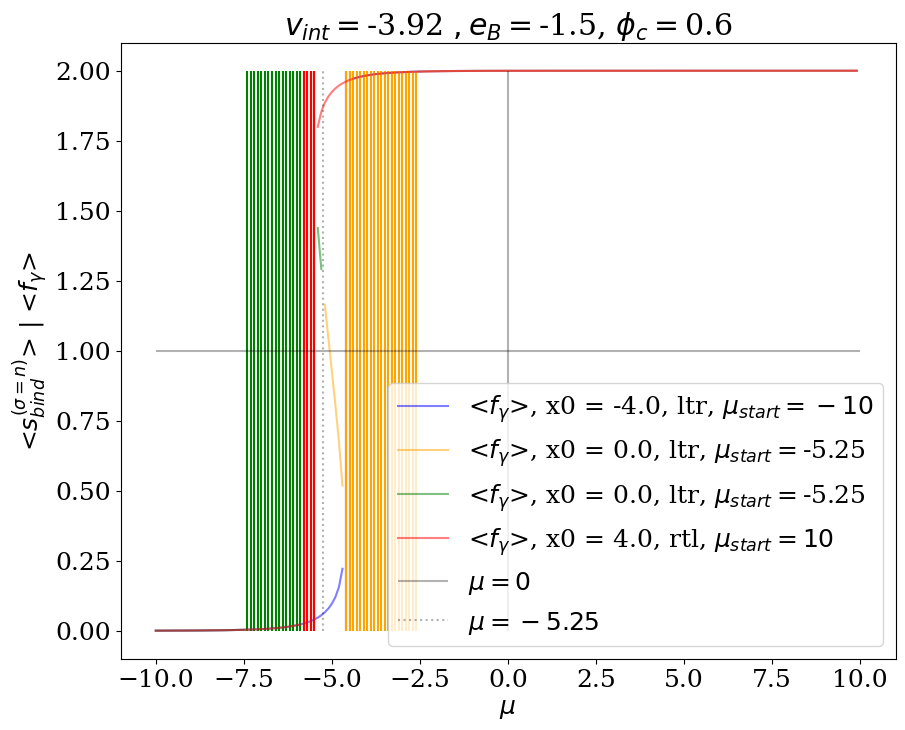

In [9]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
# lins = ["-", ":", "-.", "--"]
# lins_bnd = [":", "-", "--", "-."]
lins = ["-"]*6

colors = ["blue","orange","green","red", "pink", "purple"]
for j,x0 in enumerate(x0_arr[:]):
    print(x0)
#     x0_direct = x0_arr_direct[j]
#     if j <= 2:
#         msg = ", ltr"
#     else:
#         msg = ", rtl"
#     if j == 1 or j == 2 or j ==3 or j == 4:
#         msg2 = ", $\mu_{start} = $"+ str(mu_mid)
#     elif j ==0:
#         msg2 =  ", $\mu_{start} = -10$"
#     elif j ==5:
#          msg2 = ", $\mu_{start} = 10$"

    if j <= 2:
        msg = ", ltr"
    else:
        msg = ", rtl"
    if j == 1 or j == 2:
        msg2 = ", $\mu_{start} = $"+ str(mu_mid)
    elif j ==0:
        msg2 =  ", $\mu_{start} = -10$"
    elif j ==3:
         msg2 = ", $\mu_{start} = 10$"
            
#     if x0[0] > -2 and x0[0] < 2:
#     if j ==3 or j == 0 :
    plt.plot(mu_arrs[j], f_bar_arr_arr[j], label = "<$ f_{\gamma} $>, x0 = " + str(x0[0]) + msg +msg2, linestyle = lins[j], alpha = 0.5, color = colors[j])
    plt.vlines(mu_fail_arr_arr[j], 0,2,color = colors[j])

#     if j == 3:
#         plt.plot(mu_arrs[j], f_bar_arr_arr[j], label = "<$ f_{\gamma} $>, x0 = " + str(x0[0]) + msg +msg2, color = colors[j])
#         plt.vlines(mu_fail_arr_arr[j], 0,2, linestyle = ":")
#     plt.plot(mu_arrs[j], f_bar_arr_arr_direct[j], label = "drct bndd, <$ f_{\gamma} $>, x0 = " + str(x0_direct[0]) + msg +msg2, linestyle = lins_bnd[j], alpha = 0.5)


plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
plt.xlabel("$\mu$")
plt.title("$v_{int} = $" + str(v_int[0][0]) +  " $,e_B = $" + str(e_m[0]) + ", $\phi_c = $" + str(phi_c))
plt.hlines(1, -10, 10, color = "black", alpha = 0.3)
# plt.vlines(-.75, 0,2, color = "black", alpha = 0.3, label = "$\mu = -0.75$")
plt.vlines(-0, 0,2, color = "black", alpha = 0.3, label = "$\mu = 0$")
plt.vlines(-5.25, 0,2, color = "black", alpha = 0.3, label = "$\mu = -5.25$", linestyle = ":")
plt.legend()

# why is s_bind = 2 * (exp(x \ (1 + exp)))? how did that realtion come about. it is to allow for unbounded minimizationq
#check solver- intial conditions? 

In [ ]:
mu_fail_arr_arr[3]

In [ ]:
# plt.plot(mu_array, f_bar_arr, label = "<$ f_{\gamma} $>", color = "blue", alpha = 0.5, linestyle= ":")
# plt.xlabel("$\mu$")
# plt.ylabel("<$ f_{\gamma} $>")

# plt.plot(mu_array, s_bind_0sig, linestyle = "--", label = "n = 0", color = "green")
# # plt.xlabel("$\mu$")
# # plt.ylabel("<$ s_{bind}^{(\sigma = 0)}$>")

# plt.plot(mu_array, s_bind_1sig, linestyle = "--", label = "n = 1", color = "red")
# # plt.xlabel("$\mu$")
# # plt.ylabel("<$ s_{bind}^{(\sigma = 1)}$>")

# plt.plot(mu_array, s_bind_2sig, linestyle = "--", label = "n = 2", color = "orange")
# # plt.xlabel("$\mu$")
# plt.ylabel("<$ s_{bind}^{(\sigma = 2)}$>")

# LANGMUIR. Assumptions only valid when v_int = 0, and for sigma =0 or 2 (all sites identical)
# K = np.exp(-e_m)
# plt.plot(mu_array, 2*K*np.exp(mu_array) / (1+ K*np.exp(mu_array)), label = "langmuir", linestyle = ":", color = "black")

# K = np.exp(-0)  # sigma = 0 - all binding energies are 0
# plt.plot(mu_array, 2*K*np.exp(mu_array) / (1+ K*np.exp(mu_array)), label = "langmuir, e_b = 0", linestyle = "-.", color = "black")


### single mu analysis

In [ ]:
n_bind = 1 #types of proteins/marks

e_m = np.array([-1.5]) #binding energy
# e_m = np.array([0]) #binding energy
f_om = np.array([1/3, 1/3, 1/3]) # fraction of nucleosomes with 0,1,2 marks per protein type
v_int = np.array([[-3.92]]) # protein-protein interaction param
# v_int = np.array([[-1.8]]) # protein-protein interaction param
# v_int = np.array([[-5]])
phi_c = 0.6# avg amount of chromosome 

x = np.zeros(n_bind * 3)

# eval_opt_func(x, mu, e_m, v_int, f_om, phi_c)

In [ ]:
# UNBOUNDED. Test if any initial condition can lead to a found solution
mu_array = [-5.5]
mul = len(mu_array)
ones = np.ones(n_bind * 3)

x0_min = -10
x0_mid = 0
x0_max = 10

#for -5.2
x0_min = -6
x0_max = 6

# x0_arr = np.array([ones * x0_min, ones * x0_mid, ones * x0_mid, ones * x0_max])
x0_rng = np.arange(x0_min, x0_max, 1)
x0_arr = (np.ones((len(x0_rng), n_bind*3)).T * x0_rng).T
# #need mu split at mu = -7.75
# mu_mid = -6.3
# mu_arrs = [mu_array, mu_array[np.where(mu_array > mu_mid)], mu_array[np.where(mu_array < mu_mid)][::-1], mu_array[::-1]]
# mu_fail_arr_arr = np.zeros(len(x0_arr), dtype = object)
# f_bar_arr_arr = np.zeros(len(x0_arr), dtype = object)

f_bar_arr = np.zeros(len(x0_arr))
# mu_fail_arr_arr = np.zeros(len(x0_arr), dtype = object)

for j,x0 in enumerate(x0_arr):
    print("x0: ", x0[0])
#     print("mu arr [0]: ", mu_ar[0])
#     s_bind_0sig = np.zeros(len(mu_ar))
#     s_bind_1sig = np.zeros(len(mu_ar))
#     s_bind_2sig = np.zeros(len(mu_ar)) 
#     mu_fail_arr = np.array([])
#     for i,mu in enumerate(mu_ar):
#         print("x0: ", x0)
    s_bind, mu_fail_arr = eval_s_bind(mu_array, e_m, v_int, f_om, phi_c, x0, mu_fail_arr)
    #     print("s_bind:")
    #     print(s_bind)
    #     print(s_bind[0:(0 + 3)])
    #     f_bar = np.sum(f_om[0:(0 + 3)] * s_bind[0:(0 + 3)])
    f_bar = np.sum(f_om * s_bind)
#         s_bind_0sig[i] = s_bind[0]
#         s_bind_1sig[i] = s_bind[1]
#         s_bind_2sig[i] = s_bind[2]
#         f_bar_arr[i] = f_bar
#         x0 = [s_bind[0], s_bind[1], s_bind[2]]
    
    f_bar_arr[j] = f_bar
    print("f_bar: ", f_bar)
    print("xxxxxxxxxx end of one iter xxxxxxxxxxxxxxxx")

#     mu_fail_arr_arr[j] = mu_fail_arr

In [ ]:
#SEE TWO SOLUTINS!!! yessirrr. change so NOT using previous binding state, always resetting to +3 or -3

## Langmuir isotherm analysis two proteins

In [ ]:
n_bind = 2 #types of proteins/marks

# e_m = np.array([-1.5, -1.5]) #binding energy
e_m = np.array([0,-1.5]) #binding energy
f_om = np.array([1/3, 1/3, 1/3, 1/3, 1/3, 1/3]) # fraction of nucleosomes with 0,1,2 marks per protein type
# v_int = np.array([[-3.92, 3.0],[3.0, -3.92]])
# v_int = np.array([[-1,1],[1,-1]]) # protein-protein interaction param
v_int = np.array([[0,0],[0,0]]) # protein-protein interaction param
phi_c = 1# avg amount of chromosome 

x = np.zeros(n_bind * 3)

# eval_opt_func(x, mu, e_m, v_int, f_om, phi_c)

In [ ]:
#2d mu array??
mu1_array = np.arange(-10, 10, .1)
mu2_array = [0,10,-10]#np.arange(-10, 10, .1)

f_bar1_arr = np.zeros((len(mu1_array), len(mu2_array)))
f_bar2_arr = np.zeros((len(mu1_array), len(mu2_array)))
f_bar_arrs = [f_bar1_arr, f_bar2_arr]

s_bind1_0sig = np.zeros((len(mu1_array), len(mu2_array)))
s_bind1_1sig = np.zeros((len(mu1_array), len(mu2_array)))
s_bind1_2sig = np.zeros((len(mu1_array), len(mu2_array)))

s_bind2_0sig = np.zeros((len(mu1_array), len(mu2_array)))
s_bind2_1sig = np.zeros((len(mu1_array), len(mu2_array)))
s_bind2_2sig = np.zeros((len(mu1_array), len(mu2_array)))

for i, mu1 in enumerate(mu1_array):
    for j, mu2 in enumerate(mu2_array):
        s_bind = eval_s_bind([mu1, mu2], e_m, v_int, f_om, phi_c)
        for mark in range(n_bind):
            f_bar_array = f_bar_arrs[mark]
            ind0 = mark * 3
            f_bar_array[i,j] = np.sum(f_om[ind0:(ind0 + 3)] * s_bind[ind0:(ind0 + 3)])
            f_bar_arrs[mark] = f_bar_array
            
        s_bind1_0sig[i,j] = s_bind[0]
        s_bind1_1sig[i,j] = s_bind[1]
        s_bind1_2sig[i,j] = s_bind[2]
        
        s_bind2_0sig[i,j] = s_bind[3]
        s_bind2_1sig[i,j] = s_bind[4]
        s_bind2_2sig[i,j] = s_bind[5]

f_bar1_arr = f_bar_arrs[0]
f_bar2_arr = f_bar_arrs[1]

In [ ]:
# s_bind2_0sig

In [ ]:
# s_bind1_0sig

In [ ]:
# f_bar1_arr#[:,0]

In [ ]:
# f_bar1_arr[:,2]

In [ ]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(mu1_array, f_bar1_arr[:,0], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = 0$", color = "blue")
# plt.xlabel("$\mu$")
# plt.ylabel("<$ f_{\gamma} $>")

plt.plot(mu1_array, f_bar1_arr[:,1], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = 10$", color = "green", linestyle = "-.")

plt.plot(mu1_array, f_bar1_arr[:,2], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = -10$", color = "red", linestyle = "--", zorder = 4)

# plt.plot(mu1_array, f_bar_arr, label = "<$ f_{\gamma}^{(1)} $> single protein", color = "black")

# LANGMUIR. Assumptions only valid when v_int = 0, and for sigma =0 or 2 (all sites identical)
K = np.exp(-e_m[0])
plt.plot(mu1_array, 2*K*np.exp(mu1_array) / (1+ K*np.exp(mu1_array)), label = "langmuir", linestyle = ":", color = "black")

# K = np.exp(-0)  # sigma = 0 - all binding energies are 0
# plt.plot(mu_array, 2*K*np.exp(mu_array) / (1+ K*np.exp(mu_array)), label = "langmuir, e_b = 0", linestyle = "-.", color = "black")

# plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
# plt.xlabel("$\mu$")

plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
plt.xlabel("$\mu^{(1)}$")
plt.title("$v_{int} = $" + str(v_int) +  ", $e_B^{(1)} = $" + str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]))
plt.hlines(1, -10, 10, color = "black", alpha = 0.3)
# plt.vlines(-.75, 0,2, color = "black", alpha = 0.3, label = "$\mu = -0.75$")
plt.vlines(-0, 0,2, color = "black", alpha = 0.3, label = "$\mu = 0$")
plt.legend()

# why is s_bind = 2 * (exp(x \ (1 + exp)))? how did that realtion come about. it is to allow for unbounded minimizationq
#check solver- intial conditions? 

## $\langle s_{i}^{(\gamma_1)} s_{j}^{(\gamma_1')} \rangle$ calculation

In [ ]:
def eval_f_bind_vec(n_b, n_m_arr, e_m = -1.5, j_int = -3.92):
    r"""
    eval_f_bind - Evaluate the binding free energy
    
    Parameters
    ----------
    n_b : integer
        array of Number of reader proteins bound to the nucleosome
    n_m_arr : arr of integer
        Number of marked tails
    e_me3 : float
        Favorable binding free energy to tri-methylated tails
        
    Returns
    -------
    f_bind : float
        Binding free energy
    
    """
    # Calculate the cases for the binding free energy
    f_bind_arr = np.zeros(len(n_m_arr))
    for i,n_m in enumerate(n_m_arr):
        f_bind = 0
        if n_b == 0:
            f_bind = 0
        elif n_b == 1:
            if n_m == 0:
                f_bind = -np.log(2)
            elif n_m == 1:
                f_bind = -np.log(1. + np.exp(-e_m))
            elif n_m == 2:
                f_bind = e_m - np.log(2)
        elif n_b == 2:
            if n_m == 0:
                f_bind = j_int
            elif n_m == 1:
                f_bind = e_m + j_int
            elif n_m == 2:
                f_bind = 2 * e_m + j_int
        f_bind_arr[i] = f_bind
    return f_bind_arr

In [ ]:
# need to produce rank 2 tensor that, given two protein types, 
# find avg of product of s for index ij
def eval_sisj_bind(s_bind, mu, e_m, v_int, f_om, phi_c, poly_marks, gam1_ind, gam2_ind):
    '''
    poly marks (array of arrays) contains an array of marks per nucleosome for each protein type
    gam1_ind (int) is the index of first protein
    gam2_ind (int) is the index of second protein
    '''
    
    n_bind = len(mu)
    # evaluate eqn 85 for each index ij
 
    phi_bind = np.zeros(n_bind) #phi_c times f_gamma
    for mark in range(n_bind):
        ind0 = mark * 3             # VVV calc of bar{f}_\gamma (eqn 86) VVV
        phi_bind[mark] = phi_c * np.sum(f_om[ind0:(ind0 + 3)] * s_bind[ind0:(ind0 + 3)]) 
    erg_int = np.matmul(v_int, phi_bind) #sum over gamma 2 of int and phi and f
    
    coef1 = erg_int[gam1_ind] + mu[gam1_ind] 
    coef2 = erg_int[gam2_ind] + mu[gam2_ind]
    
    #make vector form of f_bind
    f_bind_g1_s1 = eval_f_bind_vec(1, poly_marks[gam1_ind], e_m[gam1_ind])
    f_bind_g1_s2 = eval_f_bind_vec(2, poly_marks[gam1_ind], e_m[gam1_ind])
    f_bind_g2_s1 = eval_f_bind_vec(1, poly_marks[gam2_ind], e_m[gam2_ind])
    f_bind_g2_s2 = eval_f_bind_vec(2, poly_marks[gam2_ind], e_m[gam2_ind])
    
    #combine coef and f_bind to create 4 dif energies needed
#     - each should be rank 2 tensors
    
    exp_g1_s1 = np.exp(coef1 + f_bind_g1_s1)
    exp_g1_s2 = np.exp(2*coef1 + f_bind_g1_s2)
    exp_g2_s1 = np.exp(coef2 + f_bind_g2_s1)
    exp_g2_s2 = np.exp(2*coef2 + f_bind_g2_s2)
    
    exp_11 = np.outer(exp_g1_s1, exp_g2_s1)
    exp_12 = np.outer(exp_g1_s1, exp_g2_s2)
    exp_21 = np.outer(exp_g1_s2, exp_g2_s1)
    exp_22 = np.outer(exp_g1_s2, exp_g2_s2)
    
#     # calc q_0 (all probabilities)
    q = 1 + np.outer(exp_g1_s1, exp_g1_s1) + np.outer(exp_g2_s1, exp_g2_s1)\
    + np.outer(exp_g1_s2, exp_g1_s2) + np.outer(exp_g2_s2, exp_g2_s2)\
    + exp_11 + exp_12 + exp_21 + exp_22
    
    #calculate average matrix (eq 85)
    sisj_bind = (exp_11 + exp_12 + exp_21 + exp_22) / q
    return sisj_bind 

In [ ]:
n_bind = 2 #types of proteins/marks

mu = np.array([-4.5, -5]) #chemical potential in solution
e_m = np.array([-1.5, -1.5]) #binding energy
f_om = np.array([0.5, 0, 0.5, 0.75, 0, 0.25]) # fraction of nucleosomes with 0,1,2 marks per protein type
v_int = np.array([[-3.92, 3.0],[3.0, -3.92]]) # protein-protein interaction param
phi_c = 0.6 # avg amount of chromosome 

x = np.zeros(n_bind * 3)

marks_1 = [0,2,0,2] # marks for protein 1
marks_2 = [0,0,0,2] # marks for protein 2
poly_marks = [marks_1, marks_2]
eval_opt_func(x, mu, e_m, v_int, f_om, phi_c)

In [ ]:
s_bind = eval_s_bind(mu, e_m, v_int, f_om, phi_c)
s2_bind = eval_s2_bind(s_bind, mu, e_m, v_int, f_om, phi_c)

In [ ]:
eval_sisj_bind(s_bind, mu, e_m, v_int, f_om, phi_c, poly_marks, 0, 0)

## Determine the effective $\chi$-parameter matrix (andy)

In [ ]:
def eval_chi_mat(mu, e_m, v_int, f_om, phi_c):
    n_bind = len(mu)
    chi_mat = np.zeros((3 * n_bind, 3 * n_bind))
    
    s_bind = eval_s_bind(mu, e_m, v_int, f_om, phi_c)
    
    for m1 in range(n_bind):
        for s1 in range(3):
            i1 = m1 * 3 + s1
            for m2 in range(n_bind):
                for s2 in range(3):
                    i2 = m2 * 3 + s2
                    e12 = 0.5 * s_bind[i1] * v_int[m1, m2] * s_bind[i2]
                    e11 = 0.5 * s_bind[i1] * v_int[m1, m1] * s_bind[i1]
                    e22 = 0.5 * s_bind[i2] * v_int[m2, m2] * s_bind[i2]
                    chi_mat[i1, i2] = e12 - 0.5 * (e11 + e22)
    
    return chi_mat

In [ ]:
n_bind = 2

mu = np.array([-5, -5])
e_m = np.array([-1.5, -1.5])
f_om = np.array([0.5, 0, 0.5, 0.5, 0, 0.5])
v_int = np.array([[-3.92, .0],[.0, -3.92]])
phi_c = 0.6

s_bind = eval_s_bind(mu, e_m, v_int, f_om, phi_c)
chi_mat = eval_chi_mat(mu, e_m, v_int, f_om, phi_c)

In [ ]:
print(chi_mat[0, 2])
print(chi_mat[3, 5])
print(chi_mat[2, 5])

In [ ]:
s_bind

In [ ]:
chi_mat